In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.visualization import circuit_drawer
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import datasets
from sklearn.preprocessing import normalize, StandardScaler

/Users/i335439/Desktop/QML/venv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


## Getting the Iris dataset

In [2]:
iris = datasets.load_iris()

In [3]:
irisData = pd.DataFrame({_[0]: iris.data[:, _[1]] for _ in zip(iris.feature_names, range(len(iris.feature_names)))})
labelNames = {_[0]: _[1] for _ in zip(range(len(iris.target_names)), iris.target_names)}
irisData['label'] = [labelNames[_] for _ in iris.target]

In [15]:
setosa = irisData[irisData['label'] == 'setosa']
versicolor = irisData[irisData['label'] == 'versicolor']
virginica = irisData[irisData['label'] == 'virginica']

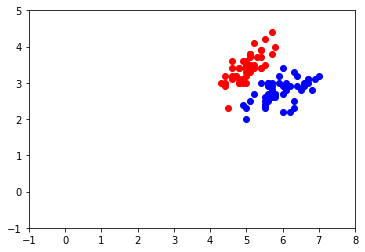

In [16]:
fig, ax = plt.subplots()
ax.scatter(versicolor['sepal length (cm)'], versicolor['sepal width (cm)'], color='b')
ax.scatter(setosa['sepal length (cm)'], setosa['sepal width (cm)'], color='r')
ax.set_xlim([-1, 8]); ax.set_ylim([-1, 5]); ax.set_aspect('equal')

In [17]:
selectedData = irisData[irisData['label'].isin(['versicolor', 'setosa'])]
selectedData = selectedData[['sepal length (cm)', 'sepal width (cm)', 'label']]

scaler = StandardScaler().fit(selectedData[['sepal length (cm)', 'sepal width (cm)']])
normalizedData = scaler.transform(selectedData[['sepal length (cm)', 'sepal width (cm)']])
normalizedData = normalize(normalizedData)

normalizedData = pd.DataFrame({'sepal length (cm)': normalizedData[:, 0],
                               'sepal width (cm)': normalizedData[:, 1],
                               'label': selectedData['label']})

In [18]:
normVersicolor = normalizedData[normalizedData['label'] == 'versicolor']
normSetosa = normalizedData[normalizedData['label'] == 'setosa']

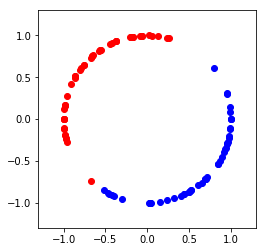

In [20]:
fig, ax = plt.subplots()
ax.scatter(normVersicolor['sepal length (cm)'], normVersicolor['sepal width (cm)'], color='b')
ax.scatter(normSetosa['sepal length (cm)'], normSetosa['sepal width (cm)'], color='r')
ax.set_xlim([-1.3, 1.3]); ax.set_ylim([-1.3, 1.3]); ax.set_aspect('equal')

## Samples selected in the EPL article

In [30]:
normalizedData.iloc[[33, 85, 28, 36, 55]]

,sepal length (cm),sepal width (cm),label
33,0.019647,0.999807,setosa
85,0.795134,0.606434,versicolor
28,-0.557585,0.830120,setosa
36,0.053875,0.998548,setosa
55,0.496113,-0.868258,versicolor


# Nearset neighbor classifier

We are using 2 training vectors:
$$
\begin{align}
x_0 = (0.019647, 0.999807) \quad & y_0 = 0 \quad (\text{setosa}) \\
x_1 = (0.795134, 0.606434) \quad & y_1 = 1 \quad (\text{versicolor})
\end{align}
$$

and we look for (euclidean distance) nearest neighbor to a new vector $x^\prime$.

In [61]:
#x0 = [0.0, 1.0]                # class 0

x0 = [0.019647, 0.999807]      # class 0
x1 = [0.788610, 0.614894]      # class 1

#xprime = [-0.549104, 0.835754] # class 0
#xprime = [-0.557585, 0.830120]

xprime = [0.496113, -0.868258]

# xprime2 = [0.052917, 0.998599] # class 0
# xprime3 = [0.612361, -0.790579] # class 1 (sample 87)
# xprime4 = [0.036196, -0.999345] # class 1 (sample 89)
# xprime5 = [-0.169638, 0.985506] # class 0 (sample 20)

## Initialize the quantum circuit

In [62]:
numbQubits = 4
q, c = QuantumRegister(numbQubits), ClassicalRegister(numbQubits)


shots, timeout = 5000, 10000

circuit = QuantumCircuit(q, c)

thetaPrime = 2 * np.arctan2(xprime[1], xprime[0])
# thetaPrime = 2 * np.arctan2(xprime2[1], xprime2[0])
# thetaPrime = 2 * np.arctan2(xprime3[1], xprime3[0])
# thetaPrime = 2 * np.arctan2(xprime4[1], xprime4[0])
# thetaPrime = 2 * np.arctan2(xprime5[1], xprime5[0])
#thetaPrime_finger = 3.0357101997648965 / 2

theta1 = np.arctan2(x1[1], x1[0])

## QML circuit

In [63]:

circuit.h(q[0])
circuit.h(q[1])

circuit.cu3(thetaPrime, 0, 0, q[0], q[2])

circuit.x(q[0])
circuit.ccx(q[0], q[1], q[2])
circuit.x(q[1])
circuit.ccx(q[0], q[1], q[2])

circuit.cu3(- theta1, 0, 0, q[1], q[2])
circuit.ccx(q[0], q[1], q[2])
circuit.cu3(theta1, 0, 0, q[1], q[2])

circuit.cx(q[1], q[3])

circuit.h(q[0])

circuit.measure(q, c)



/Users/i335439/Desktop/QML/venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)
WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


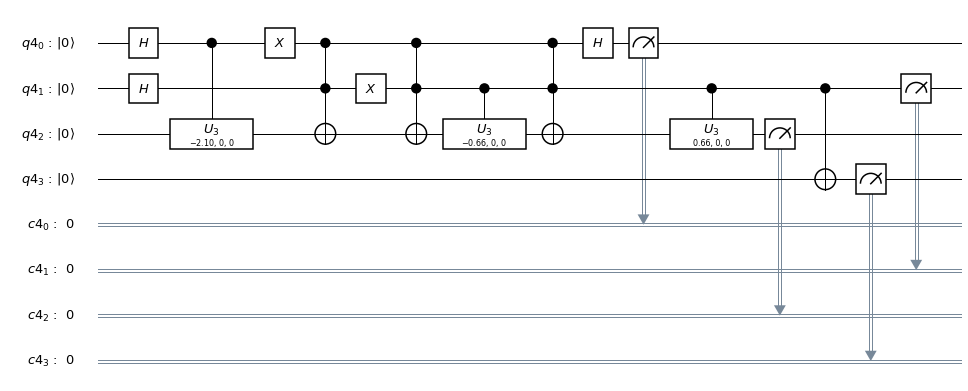

In [64]:
circuit_drawer(circuit)

In [65]:
qmlResult = execute(circuit, backend = BasicAer.get_backend('qasm_simulator'), shots = shots)
qmlCounts = qmlResult.result().get_counts(circuit)

for _ in qmlCounts:
    qmlCounts[_] = qmlCounts[_] / shots

qmlProbabilities = OrderedDict(sorted(qmlCounts.items()))

print(qmlProbabilities)

OrderedDict([('0000', 0.031), ('0001', 0.0306), ('0100', 0.0024), ('0101', 0.431), ('1010', 0.2054), ('1011', 0.0102), ('1110', 0.0062), ('1111', 0.2832)])


## Probabilities

In [66]:
def vectorPlus(vec1, vec2):
    return [vec1[0] + vec2[0], vec1[1] + vec2[1]]

def vectorMinus(vec1, vec2):
    return [vec1[0] - vec2[0], vec1[1] - vec2[1]]

def normCalc(vec):
    return (vec[0] ** 2) + (vec[1] ** 2)

## acceptance probabilities for measurement of ancilla in |0> or |1>

In [67]:
def probCalculator(testVector):
    PrAlpha0Theory = (normCalc(vectorPlus(testVector, x0)) + normCalc(vectorPlus(testVector, x1))) / (4 * 2)
    PrAlpha1Theory = (normCalc(vectorMinus(testVector, x0)) + normCalc(vectorMinus(testVector, x1))) / (4 * 2)

    PrAlpha0QML = sum([qmlCounts[_] for _ in qmlProbabilities if _[3] == '0'])
    PrAlpha1QML = sum([qmlCounts[_] for _ in qmlProbabilities if _[3] == '1'])

    print('Pr(alpha=0)\ttheory = %.3f\tqml = %.3f' % (PrAlpha0Theory, PrAlpha0QML))
    print('Pr(alpha=1)\ttheory = %.3f\tqml = %.3f' % (PrAlpha1Theory, PrAlpha1QML))
    print('sum\t\ttheory = %.3f\tqml = %.3f' % (PrAlpha0Theory + PrAlpha1Theory, PrAlpha0QML + PrAlpha1QML))
    
    return PrAlpha0QML, PrAlpha1QML
    
PrAlpha0QML, PrAlpha1QML = probCalculator(xprime)
# PrAlpha0QML, PrAlpha1QML = probCalculator(xprime2)
# PrAlpha0QML, PrAlpha1QML = probCalculator(xprime3)
# PrAlpha0QML, PrAlpha1QML = probCalculator(xprime4)
# PrAlpha0QML, PrAlpha1QML = probCalculator(xprime5)

Pr(alpha=0)	theory = 0.250	qml = 0.245
Pr(alpha=1)	theory = 0.750	qml = 0.755
sum		theory = 1.000	qml = 1.000


In [68]:
def classPredictorAncilla0(testVector):
    probAncilla0Class0 = 1 / (4 * 2 * PrAlpha0QML) * (normCalc(vectorPlus(testVector, x0)))
    probAncilla0Class1 = 1 / (4 * 2 * PrAlpha0QML) * (normCalc(vectorPlus(testVector, x1)))
    print('Ancilla = |0>\nPr(class = 0) = %.3f ; Pr(class = 1) = %.3f ; sum = %.3f' % 
          (probAncilla0Class0, probAncilla0Class1, probAncilla0Class0 + probAncilla0Class1))
    
classPredictorAncilla0(xprime)
#classPredictorAncilla0(xprime2)
# classPredictorAncilla0(xprime3)
# classPredictorAncilla0(xprime4)
# classPredictorAncilla0(xprime5)

Ancilla = |0>
Pr(class = 0) = 0.145 ; Pr(class = 1) = 0.875 ; sum = 1.019


In [58]:
qmlProbabilities

OrderedDict([('0000', 0.0398),
             ('0001', 0.0388),
             ('0100', 0.4202),
             ('0101', 0.0036),
             ('1010', 0.008),
             ('1011', 0.2224),
             ('1110', 0.2626),
             ('1111', 0.0046)])

In [49]:
qmlCounts

{'1110': 0.2658,
 '0101': 0.0036,
 '1111': 0.0062,
 '1011': 0.2182,
 '0000': 0.0432,
 '0001': 0.0398,
 '0100': 0.4168,
 '1010': 0.0064}